In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections

In [2]:
#service handle
path = '/home/rei/reigit/service_request.txt'
f = open(path)
f.close()
with open(path) as f:
    l = f.readlines()
sh=[]
for i in l:
    sh.append(i.split('0x')[1].split(',')[0])
sh2=[]
for i in sh:
    sh2.append(str(int(i,16)))
s_counter=collections.Counter(sh2)  #how many time did they run?
service_counter=dict(s_counter)

#connect handle to service name
path = '/home/rei/reigit/avpdemo.txt'
f = open(path)
f.close()
with open(path) as f:
    l = f.readlines()
#client handle
S = l.index('Services:\n')
E = l.index('Clients:\n')
service_sn=[]
for i in l[S+3:E-1]:
    for j in service_counter.keys():
         if j == i.split()[0]:
             service_sn.append(j+':'+i.split()[4]+'--'+str(service_counter.get(str(j))))
for i in service_sn:
    print(i)

94270755960304:/planning/estimate_collision--570
94279700027568:/had_maps/HAD_Map_Service--5
94406263204912:/planning/plan_lane_trajectory/_action/send_goal--1
94406263204928:/planning/plan_lane_trajectory/_action/get_result--1


In [3]:
#client handle
path = '/home/rei/reigit/client_response.txt'
f = open(path)
f.close()
with open(path) as f:
    l = f.readlines()
ch=[]
for i in l:
    ch.append(i.split('0x')[1].split(',')[0])
ch2=[]
for i in ch:
    ch2.append(str(int(i,16)))
c_counter=collections.Counter(ch2)  #how many time did they run?
client_counter=dict(c_counter)

#connect handle to service name
path = '/home/rei/reigit/avpdemo.txt'
f = open(path)
f.close()
with open(path) as f:
    l = f.readlines()
#client handle
S = l.index('Clients:\n')
E = l.index('Timers:\n')
client_sn=[]
for i in l[S+3:E-1]:
    for j in client_counter.keys():
         if j == i.split()[0]:
             client_sn.append(j+':'+i.split()[4]+'--'+str(client_counter.get(str(j))))
for i in client_sn:
    print(i)

94406262911392:/had_maps/HAD_Map_Service--1
94236321446816:/had_maps/HAD_Map_Service--1
94578261187136:/had_maps/HAD_Map_Service--1
93865044403600:/had_maps/HAD_Map_Service--1
94094547596592:/planning/plan_lane_trajectory/_action/send_goal--1
94094547596608:/planning/plan_lane_trajectory/_action/get_result--1
94094547974016:/had_maps/HAD_Map_Service--1
94094547439536:/planning/estimate_collision--570


In [4]:
#only calculate the latency of service which execution time exceed 10
service_c=[]
for i in service_counter.keys():
    if service_counter.get(i) > 10:
        service_c.append(i)
service_p=[]
for i in service_c:
    for j in service_sn:
        if i == j.split(':')[0]:
            service_p.append(j.split('--')[0])
print('service:')
print(service_p)

client_c=[]
for i in client_counter.keys():
    if client_counter.get(i) > 10:
        client_c.append(i)
client_p=[]
for i in client_c:
    for j in client_sn:
        if i == j.split(':')[0]:
            client_p.append(j.split('--')[0])
print('client:')
print(client_p)

service:
['94270755960304:/planning/estimate_collision']
client:
['94094547439536:/planning/estimate_collision']


In [5]:
#find service pairs
pairs=[]
for i in service_p:
    for j in client_p:
        if i.split(':')[1]==j.split(':')[1]:
            ser=hex(int(i.split(':')[0]))
            cli=hex(int(j.split(':')[0]))
            pairs.append(ser+':'+cli+':'+j.split(':')[1])
print('service:client:service name')
print(pairs)

service:client:service name
['0x55bd1eebf5f0:0x559418134fb0:/planning/estimate_collision']


In [6]:
#request latency
def req(service_handle):
    path = '/home/rei/reigit/service_request.txt'
    f = open(path)
    f.close()
    with open(path) as f:
        l = f.readlines()
    request=[]
    for i in l:
        service = i.split(",")[4].split(" = ")[1]
        if (service == service_handle):
            source = i.split(",")[5].split(" = ")[1]
            receive = i.split(",")[6].split(" = ")[1].split()[0]
            req = int(receive) - int(source)
            request.append(req)

    request_us = []
    for i in request:
        request_us.append(i/1000)
    print(len(request_us),max(request_us),min(request_us))
    return request_us

In [7]:
#response latency
def res(client_handle):
    path = '/home/rei/reigit/client_response.txt'
    f = open(path)
    f.close()
    with open(path) as f:
        l = f.readlines()
    response=[]
    for i in l:
        client = i.split(",")[4].split(" = ")[1]
        if (client == client_handle):
            source = i.split(",")[5].split(" = ")[1]
            receive = i.split(",")[6].split(" = ")[1].split()[0]
            res = int(receive) - int(source)
            response.append(res)

    response_us = []
    for i in response:
        response_us.append(i/1000)
    print(len(response_us),max(response_us),min(response_us))
    return response_us

In [8]:
#service callback duration
def ser_cb(service_handle):
    path = '/home/rei/reigit/avpdemo.txt'
    f = open(path)
    f.close()
    with open(path) as f:
        l = f.readlines()
    
    #service_handle -> callback_object
    S = l.index('Callback objects:\n')
    E = l.index('Callback symbols:\n')   
    cb= [line for line in l[S:E] if service_handle in line]
    callback_object=[]
    for i in cb:
        callback_object.append(i.split()[2])
    #print(callback_object)
    
    #callback_object -> duration
    S = l.index('Callback instances:\n')
    E = l.index('Lifecycle state machines:\n')
    for i in callback_object:
        d= [line for line in l[S:E] if i in line]
    duration=[]
    for i in d:
        duration.append(i.split()[3])
    #print(duration)
    
    cbd_us = []
    for i in duration:
        cbd_us.append(int(i)/1000)
    print(len(cbd_us),max(cbd_us),min(cbd_us))
    return cbd_us

In [9]:
#plot a graph
def graph(latency, title):
    fig, ax = plt.subplots(1, 1)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.hist(latency, bins=100)
    plt.title("%s"%title, fontsize=15)
    plt.xlabel("Latency [us]", fontsize=15)
    plt.ylabel("Sample", fontsize=15)
    plt.savefig("%s"%title+".pdf")

service:client:service name
['0x55bd1eebf5f0:0x559418134fb0:/planning/estimate_collision']
570 3688.957 54.501
570 3138.582 27.967
570 1504.301 102.579
570 4029.357 212.252


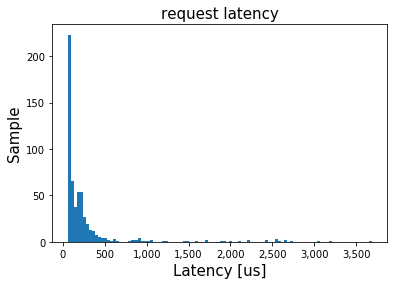

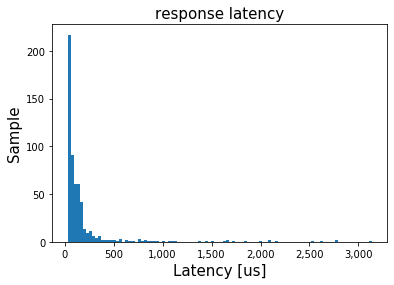

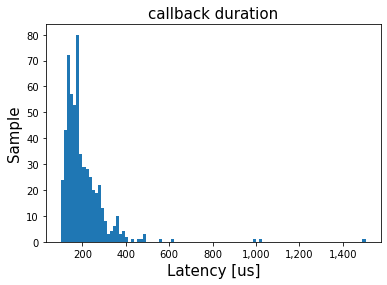

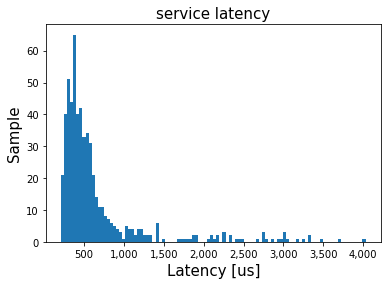

In [11]:
print('service:client:service name')
print(pairs)
for i in pairs:
    request=req(i.split(':')[0].upper().replace('X', 'x'))
    graph(request, "request latency")
    response=res(i.split(':')[1].upper().replace('X', 'x'))
    graph(response, "response latency")
    cbd=ser_cb(str(int(i.split(':')[0],16)))
    graph(cbd, "callback duration")
    service_latency = [request[i]+response[i]+cbd[i] for i in range(min(len(request),len(response),len(cbd)))]
    print(len(service_latency),max(service_latency),min(service_latency))
    graph(service_latency, "service latency")